==== Import Data ====
{ProgramChecked, ValueEncoded, GetAccountContractCode, 
 
>   UpdateAccountContractCode, RevokeEncodedAccountKey, GetAccountBalance, 
 
>   GetStorageCapacity, function_or_loop_call, ContractFunctionInvoke, 
 
>   SetValue, GetAccountContractNames, ResolveLocation, GetStorageUsed, 
 
>   GetAccountAvailableBalance, SetProgram, GetProgram, GetCode, ValueExists, 
 
>   GetValue, ProgramInterpreted, ProgramParsed, EmitEvent, 
 
>   AddEncodedAccountKey, AllocateStorageIndex, CreateAccount, ValueDecoded}


{add and remove key to/from account, add key to account, borrow array from storage, 
 
>   call empty contract function, convert int to string, 
 
>   convert int to string and concatenate it, copy array from storage, 
 
>   copy array from storage and save a duplicate, create new account, 
 
>   create new account and deploy contract, emit event, 
 
>   get account and get available balance, get account and get balance, 
 
>   get account and get storage capacity, get account and get storage used, 
 
>   get public account, get signer address, get signer receiver, get signer vault, 
 
>   load and save empty string on signers address, 
 
>   load and save long string on signers address, mint NFT, reference tx, 
 
>   transfer tokens}
All weights                      26

Chosen weights                   7

Total weight data matrix rank    21

Chosen weight data matrix rank   7

Transactions types               24

Transactions                     144901
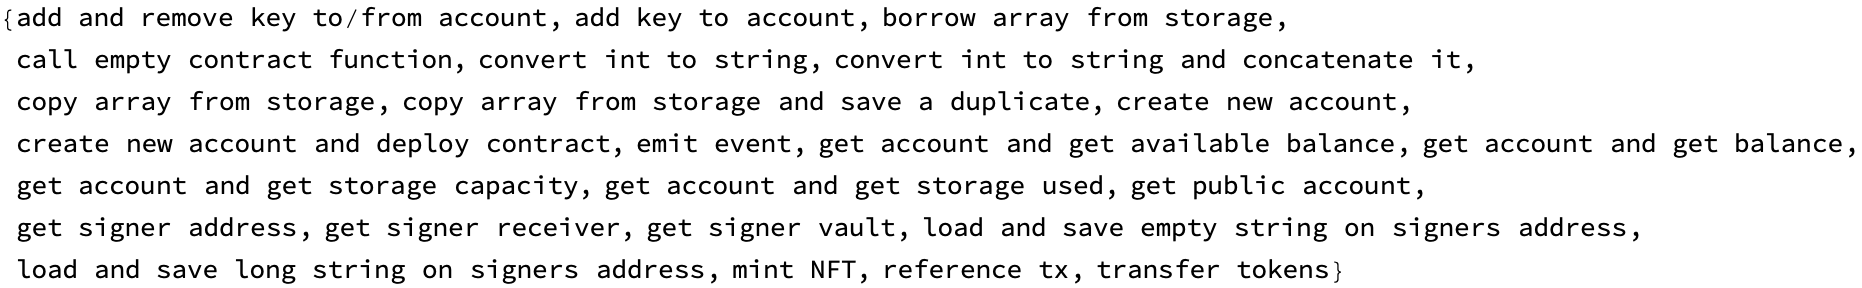
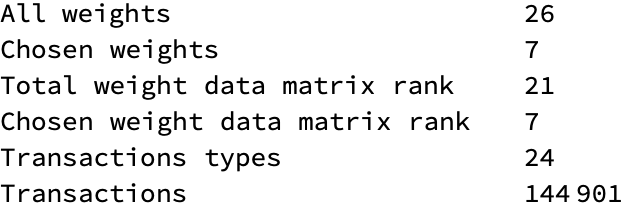

In [117]:
Print["==== Import Data ===="];

rawData = Import["/Users/janez/Programing/data-19.csv"];

allWeightsNames = rawData[[1,2;;-2]];
Print[(ToString @@@ allWeightsNames)]
weightNames = { 
(*     "ValueDecoded", *)
(*     "GetProgram", *)
    "SetValue",
    "EmitEvent",
(*     "ProgramInterpreted", *)
(*     "UpdateAccountContractCode", *)
(*     "ResolveLocation", *)
(*     "ValueExists", *)
(*     "AllocateStorageIndex", *)
(*     "GetAccountContractNames", *)
    "GetStorageUsed",
    "function_or_loop_call",
    "GetValue",
    "RevokeEncodedAccountKey",
(*     "GetAccountAvailableBalance", *)
(*     "GetAccountBalance", *)
(*     "GetStorageCapacity", *)
(*     "GetAccountContractCode", *)
(*     "ProgramParsed", *)
(*     "ContractFunctionInvoke" *)
(*     "ValueEncoded", *)
(*     "GetCode", *)
(*     "ProgramChecked", *)
(*     "CreateAccount" *)
    "AddEncodedAccountKey"
(*     "SetProgram" *)
};
(*{"function_or_loop_call", "GetValue", "SetValue"}*) (*allWeightsNames*)

weightsColumnIndecies = 
    Select[
        Table[
            {n+1,allWeightsNames[[n]]},
            {n, Length[allWeightsNames]}
        ], 
        MemberQ[weightNames, #[[2]]]&][[All,1]
    ];

transactionNames = ToString @@@ rawData[[2;;,1]];
(* Remove the fist record becuse its type is Null, these are the setup tranasctions *)
transactionTypes = Select[Drop[Union[transactionNames],1],(!StringContainsQ[ToString[#],"+"])&]


TableForm[{
    {"All weights",Length[allWeightsNames]},
    {"Chosen weights",Length[weightNames]},

    {"Total weight data matrix rank", MatrixRank[rawData[[2;;,2;;-2]]]},
    {"Chosen weight data matrix rank", MatrixRank[rawData[[2;;,weightsColumnIndecies]]]},

    {"Transactions types",Length[transactionTypes]},
    {"Transactions",Length[transactionNames]}
}]

In [128]:
res=.
r=.
c=.
v=.
M=.
names=.
lm=.
title=.
z=.
tt=.
median=.

leftCuttoff = 16.;
rightCutoff = 10.;

outlierMedian[res_] := Median[Abs[res]];
outlierWeight[r_, median_] := If[r < 0,
    If[r <= -leftCuttoff * median, 0.0, (1-(r/(leftCuttoff * median))^2)^2 ],
    If[r >= rightCutoff * median, 0.0, (1-(r/(rightCutoff * median))^2)^2 ]
];

robustLinearModelFitMaxIterations = 10;
robustLinearModelFitConvergence = 0.001;
robustLinearModelFit[v_, M_, names_] := Module[{lm, res, rr, rr1, i},
    lm = LinearModelFit[{M, v}, names, IncludeConstantBasis -> False];
    rr = N[lm["AdjustedRSquared"]];
    rr1 = 0;
    i = 1;
    While[(Abs[rr-rr1] > robustLinearModelFitConvergence) && i < robustLinearModelFitMaxIterations,
        i = i+1;
        Print[rr];
        rr1 = rr;
        res = lm["FitResiduals"];
        lm = LinearModelFit[{M, v}, 
            names, 
            Weights -> ((outlierWeight[#, outlierMedian[res]])& /@ res), 
            IncludeConstantBasis -> False
        ];
        rr = N[lm["AdjustedRSquared"]];
    ];
    lm
];


colorFunction[z_] := ColorData["SolarColors"][z];


transactionTypeIndecies[tt_] := If[
    !StringQ[tt],
    Range[2, Length[rawData]],
    Select[Range[2, Length[rawData]], (ToString[rawData[[#,1]]] == tt)&]
];

transactionTypeData[tt_] := {
    rawData[[transactionTypeIndecies[tt], -1]],
    rawData[[transactionTypeIndecies[tt], weightsColumnIndecies]]
};

plotLinearModelFit[tt_, lm_] := Module[{residuals, median, datapoint, sample,v , M},
    {v,M} = transactionTypeData[tt];
    residuals = lm["FitResiduals"];
    median = outlierMedian[residuals];
    residuals = residuals[[ transactionTypeIndecies[tt]-1 ]];
    datapoint[i_] := Style[{v[[i]],lm @@ M[[i]]}, colorFunction[outlierWeight[residuals[[i]], median]]];
    sample = If[
        Length[v]>5000,
        RandomSample[Range[Length[v]], 5000],
        Range[Length[v]]
    ];
    Style[Show[{
        ListPlot[
            Table[datapoint[i],{i, sample}],
            PlotRange -> {{0, 3000},{0, All}}, 
            AxesLabel -> {"Time to execute[ms]", "Execution effort"}, 
            PlotLabel -> tt,
            PlotLegends -> LineLegend["Data"],
            ImageSize -> Large
        ],
        Plot[x, {x, 0,1000},
            PlotStyle -> {Red,Dashed},
            PlotLegends -> LineLegend["Desired"],
            ImageSize -> Large
        ]
    }],AntiAliasing -> False]
];

plotLinearModelCorrelation[lm_, names_, f_] := Module[{ticks, corelationColor},
    ticks = {
        {Table[{i, names[[i]]}, {i, 1, Length[names]}], None}, 
        {None, Table[{i, Rotate[names[[i]], 90 Degree]}, {i, 1, Length[names]}]}
    };
    corelationColor[ z_ ] := colorFunction[f[z]];
    MatrixPlot[
        lm["CorrelationMatrix"],
        ColorFunction -> corelationColor,
        ColorFunctionScaling -> False,
        FrameTicks -> ticks
    ]
];

plotPartial[tt_, lm_ ] := Block[{vvv, MMM},
    data = transactionTypeData[tt];
    plotLinearModelFit[data[[1]], data[[2]], lm, tt]
];

In [ ]:
{v,M} = transactionTypeData[None];

lm = robustLinearModelFit[v,M,weightNames];
lm["ParameterTable"]
plotLinearModelCorrelation[lm,weightNames,(If[#==1,1,0])&]
plotLinearModelCorrelation[lm,weightNames,(#^2)&]
plotLinearModelFit[None,lm]

0.604317
0.847296
0.860127
0.862235


In [ ]:

Table[
 plotLinearModelFit[tt,lm],
    {tt, transactionTypes[[;;15]]}
]

Table[
 plotLinearModelFit[tt,lm],
    {tt, transactionTypes[[16;;]]}
]

-Graphics-
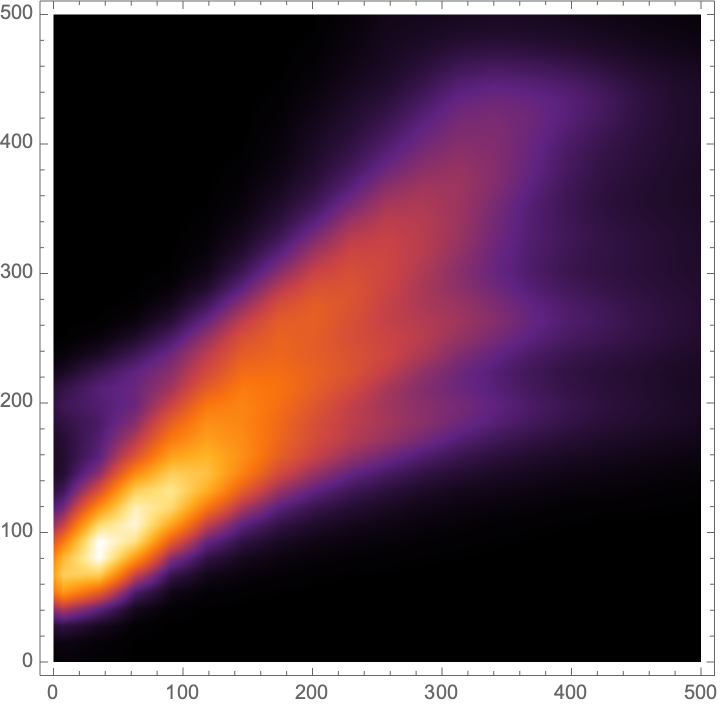

In [892]:
SmoothDensityHistogram[Table[{v[[i]],lm @@ M[[i]]},{i, Length[v]} ], PlotRange -> {{0,500},{0,500}}, PlotPoints ->200, ColorFunction -> "SunsetColors"]

In [380]:
(* trying to remove outliers *)
cutoff=.;
weightColor = ColorData["AvocadoColors"];
cutoff[res_] := 4 Median[Abs[res]];
weight[r_, c_] = If[Abs[r] >= c, 0.0, (1-(r/c)^2)^2 ];

plots = {};

plotFit[v_,M_, lm_, title_] := Module[{p1,p2,c},
(*     Print[N[lm["AdjustedRSquared"]]]; *)
    c = cutoff[lm["FitResiduals"]];
    p1 = ListPlot[Table[Style[{v[[i]],lm @@ M[[i]]},weightColor[weight[lm["FitResiduals"][[i]], c]]],{i, Length[v]} ],
        PlotRange -> {{0, All},{0, All} }, 
        AxesLabel -> {HoldForm[Time to execute[ms]], HoldForm[Computation used]}, 
        PlotLabel -> ToString[title],
        LabelStyle -> GrayLevel[0],
        PlotLegends -> LineLegend["Data"],
        ImageSize -> Large
    ];
    p2 = Plot[x, {x, 0,10000},
        PlotStyle -> {Red,Dashed},
        PlotLegends -> LineLegend["Desired"]
    ];
    Show[{p1, p2}]
];

groupKeys = Drop[Union[rawData[[2;;,1]]],1];

RobustLinearModelFitForGroup[g_] := Module[{indecies, v, M},
    indecies = Select[Range[Length[rawData]-1], (rawData[[#+1,1]] == g)&];
    v = rawData[[indecies+1,-1]];
    M = rawData[[indecies+1,headerColumns]];
    {v,M,RobustLinearModelFit[v,M,headers],g}
];

fits = Table[RobustLinearModelFitForGroup[g],{g,groupKeys}];



LinearModelFit::rank: The rank of the design matrix 5 is less than the number of terms 8 in the model. The model and results based upon it may contain significant numerical error.

LinearModelFit::rank: The rank of the design matrix 5 is less than the number of terms 8 in the model. The model and results based upon it may contain significant numerical error.

LinearModelFit::rank: The rank of the design matrix 5 is less than the number of terms 8 in the model. The model and results based upon it may contain significant numerical error.

General::stop: Further output of LinearModelFit::rank will be suppressed during this calculation.

General::munfl: Exp[-5369.28] is too small to represent as a normalized machine number; precision may be lost.

General::munfl: Exp[-5544.93] is too small to represent as a normalized machine number; precision may be lost.

General::munfl: Exp[-5570.71] is too small to represent as a normalized machine number; precision may be lost.

General::stop: Further output of General::munfl will be suppressed during this calculation.

add and remove key to/from account   0.948991
                                                 
                                                >    Estimate         Standard Error
                                                 
                                                >       t‐Statistic       P‐Value

                                                EmitEvent
                                                 
                                                >    -13.1641         10.4176
                                                 
                                                >       -1.26365          0.206439


                                                GetAccountBalance
                                                 
                                                               -7
                                                >    1.75554 10       0.
                                                 
                                                                               -323
                                                >       Infinity          0. 10

                                                SetValue
                                                 
                                                >    22.2307          12.7778
                                                 
                                                >       1.73979           0.0819812

                                                GetStorageCapacity
                                                 
                                                >    0.0673711        0.00026013
                                                 
                                                >       258.99            0.


                                                GetAccountAvailableBalance   -1.74623 
                                                 
                                                       -10
                                                >    10      0.
                                                 
                                                                            -323
                                                >    -Infinity         0. 10


                                                GetAccountContractCode
                                                 

                                                >    0.               0.
                                                 
                                                                               -323
                                                >       ComplexInfinity   0. 10

                                                UpdateAccountContractCode
                                                 
                                                >    6649.84          6139.16
                                                 
                                                >       1.08318           0.278799

                                                GetValue
                                                 
                                                >    9.96262          19.8248
                                                 
                                                >       0.502533          0.615324

add key to account   0.953234                                Estimate       Standard\
                                 
                                >    Error   t‐Statistic       P‐Value

                                EmitEvent                    -23.8798
                                 
                                >    10.2607          -2.32732          0.0200033

                                                                      -7
                                GetAccountBalance            1.9744 10
                                 
                                                                             -323
                                >    0.               Infinity          0.
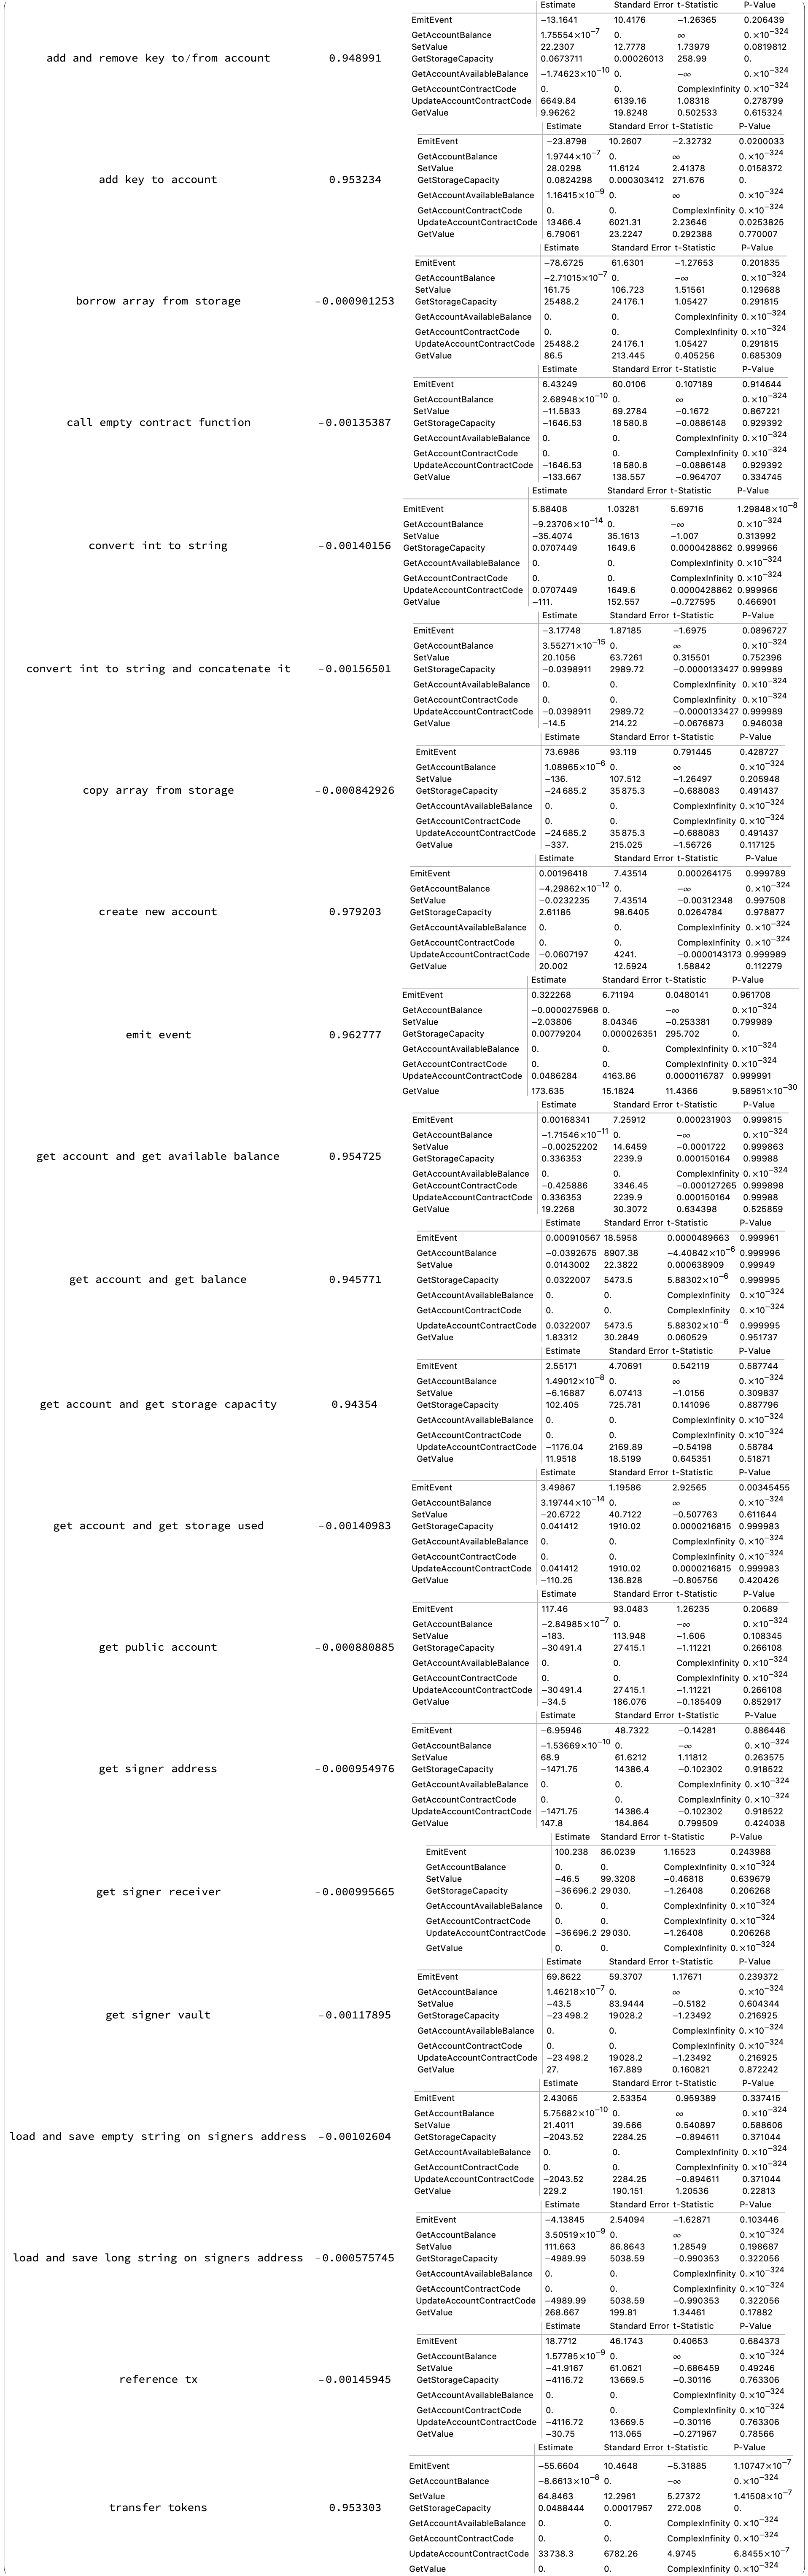
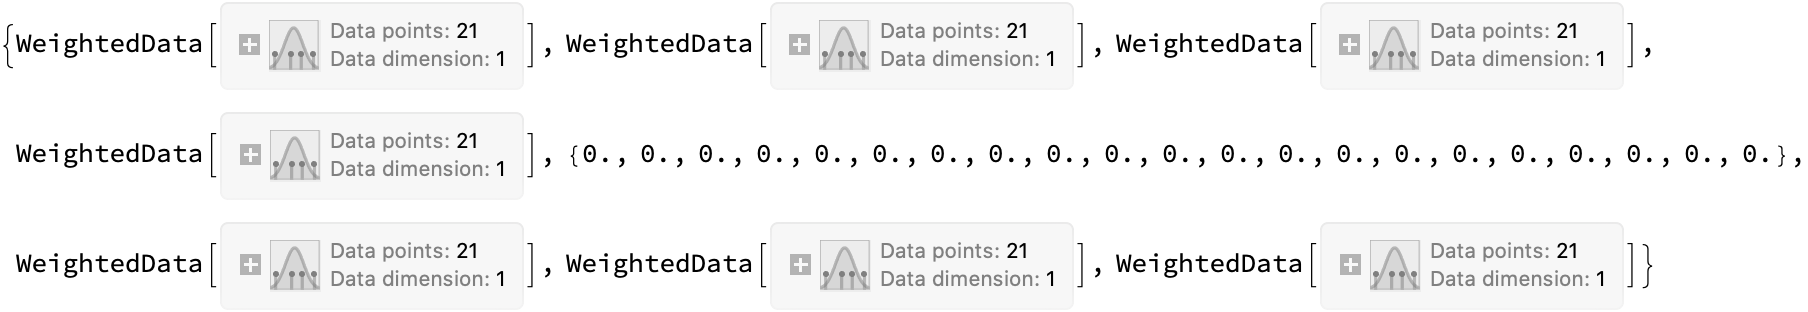
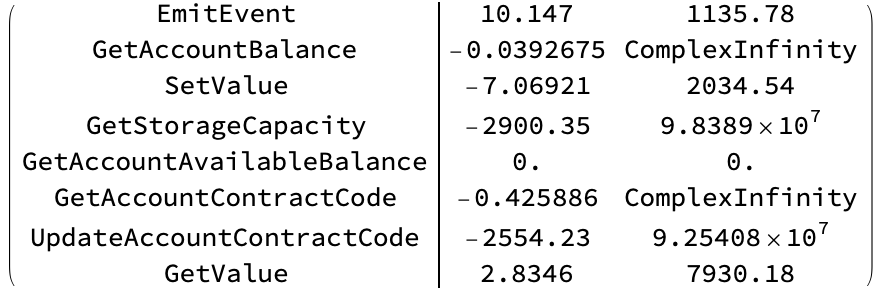

In [391]:
 MatrixForm[({#4,N[#3["AdjustedRSquared"]], #3["ParameterTable"]})& @@@ fits]


parameters = Transpose[(#3["BestFitParameters"])& @@@ fits];
pValues = Transpose[(#3["ParameterPValues"])& @@@ fits];
(* WeightedData[parameters[[0]],pValues[[0]]] *)


wp = Table[ 
    If[
        Total[ pValues[[i]] ]>0.000001, 
        WeightedData[parameters[[i]],pValues[[i]]], 
        Table[0.0,Length[parameters[[i]]]]
    ] ,{i,Length[parameters]}
]


MatrixForm[
    ({Mean[#],Variance[#]})& /@ wp, TableHeadings -> {headers,None}
]


In [ ]:

Do[plotFit @@ fits[[i]], {i, Length[fits]}]

LinearModelFit::rank: The rank of the design matrix 5 is less than the number of terms 13 in the model. The model and results based upon it may contain significant numerical error.

LinearModelFit::rank: The rank of the design matrix 5 is less than the number of terms 13 in the model. The model and results based upon it may contain significant numerical error.

LinearModelFit::rank: The rank of the design matrix 5 is less than the number of terms 13 in the model. The model and results based upon it may contain significant numerical error.

General::stop: Further output of LinearModelFit::rank will be suppressed during this calculation.

{add and remove key to/from account, add key to account, borrow array from storage, 
 
>   call empty contract function, convert int to string, 
 
>   convert int to string and concatenate it, copy array from storage, 
 
>   create new account, emit event, get account and get available balance, 
 
>   get account and get balance, get account and get storage capacity, 
 
>   get account and get storage used, get public account, get signer address, 
 
>   get signer receiver, get signer vault, 
 
>   load and save empty string on signers address, 
 
>   load and save long string on signers address, reference tx, transfer tokens}
{-Graphics-, -Graphics-, -Graphics-, -Graphics-, -Graphics-, -Graphics-, -Graphics-, 
 
>   -Graphics-, -Graphics-, -Graphics-, -Graphics-, -Graphics-, -Graphics-, -Graphics-, 
 
>   -Graphics-, -Graphics-, -Graphics-, -Graphics-, -Graphics-, -Graphics-, -Graphics-}
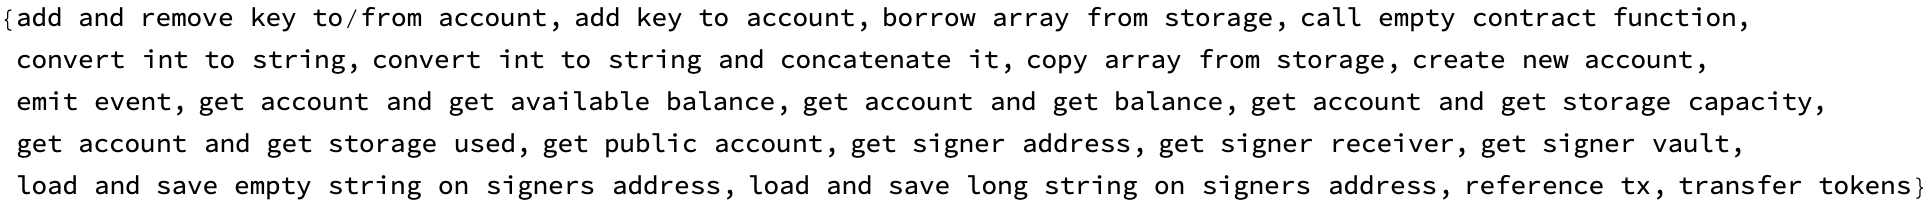
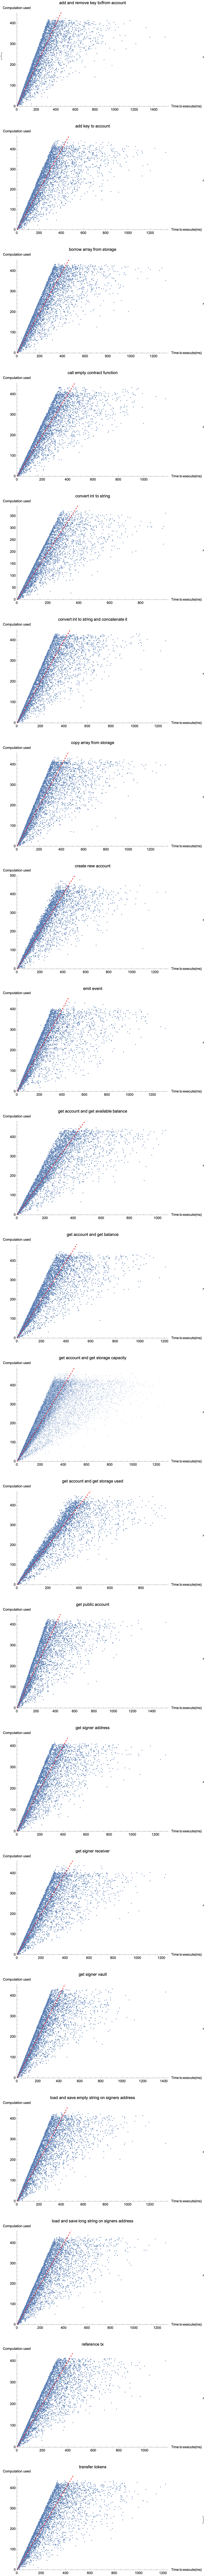

In [49]:
(* Individual fits *)
groupKeys = Drop[Union[rawData[[2;;,1]]],1]

weight[r_] := If[Abs[r] >= cutoff, 0.0, (1-(r/cutoff)^2)^2 ];

RobustLinearModelFit[M_,v_,headers_] := (
    res = LinearModelFit[{M,v},headers]["FitResiduals"];
    cutoff = 5 Median[Abs[res]];
    weight[r_] := If[Abs[r] >= cutoff, 0.0, (1-(r/cutoff)^2)^2 ];
    res = LinearModelFit[{M,v},headers, Weights-> weight/@res]["FitResiduals"];
    cutoff = 2 Median[Abs[res]];
    weight[r_] := If[Abs[r] >= cutoff, 0.0, (1-(r/cutoff)^2)^2 ];
    lmf = LinearModelFit[{M,v},headers, Weights-> weight/@res];
)

fitAndPlot[g_] := (
    indecies = Select[Range[Length[rawData]-1], (rawData[[#+1,1]] == g)&];
    v = rawData[[indecies+1,-1]];
    M = rawData[[indecies+1,headerColumns]];
    lm = RobustLinearModelFit[M,v,headers];
    Show[
        ListPlot[
            Table[
                {v[[i]],lm @@ M[[i]]}, {i, Range[Length[v]]}
            ],
             PlotRange -> {{0, All},{0, All}},  
            AxesLabel -> {HoldForm[Time to execute[ms]], HoldForm[Computation used]}, 
            PlotLabel -> ToString[g],  
            LabelStyle -> GrayLevel[0],
            PlotLegends -> LineLegend["Data"],
            ImageSize -> Large
        ],
        Plot[x, {x, 0,10000},
            PlotStyle -> {Red,Dashed},
            PlotLegends -> LineLegend["Desired"]
        ]
    ]
)

Table[
    fitAndPlot[g],
    {g, groupKeys}
]

-Graphics-
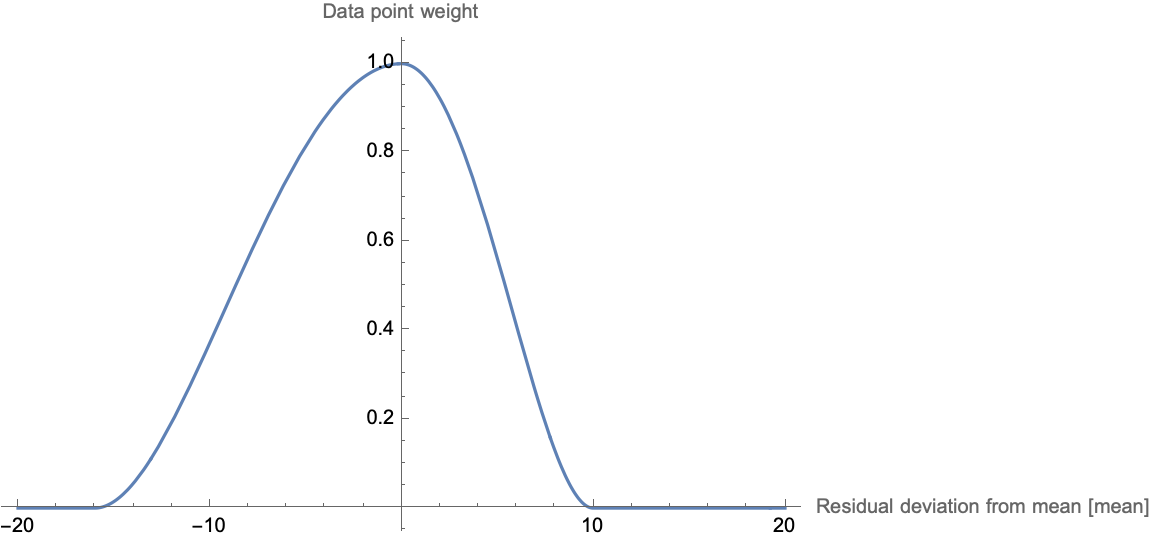

In [52]:
Plot[
    outlierWeight[x,1], 
    {x,-20,20},
    AxesLabel -> {
        "Residual deviation from mean [mean]", "Data point weight"
    },
    ImageSize -> Large
]